In [1]:
import numpy as np 
import copy
import scipy.optimize as opt
import emcee
import corner
import h5py

from model_chain import run_chain_of_models_mcmc
from sunpy.coordinates.sun import carrington_rotation_time
from model_chain import run_chain_of_models, get_ace_date
from MCMC_seven_params import *
import sunpy.map
import astropy.units as u
import os

In [2]:
# import warnings
# warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

## Bayesian Inference and Markov Chain Monte Carlo for the Ambient Solar Wind Speed

In this problem, we use Bayesian inference and Markov Chain Monte Carlo (MCMC) to find the parameters of
a chain of models that are used in space weather operational forecasting. The model and data are connected by 
$$
\mathbf{y} = \mathcal{M}(\mathbf{\theta}) + \mathbf{\eta}
$$
where $\mathbf{\theta} = \{r_{SS}, v_{0}, v_{1}, \alpha, \beta, w, \gamma\} \in \mathbb{R}^{7}$ is the set of uncertain parameters, $\mathcal{M}$ is the chain of *PFSS-WSA-HUX* models, $\mathbf{\eta}$ represents the discrepancies between the model and data, and is typically assumed to be Gaussian distributed with mean zero and covariance matrix $\mathbf{\Sigma}$, and $\mathbf{y}$ is the the radial velocity in 1hr cadance interval at L1. The radial velocity at L1 is meassured via SWEPAM monior on ACE. 

In [4]:
# get data
# exclude 2051 since there were 3 CMEs during this time period.
list_of_carrington_rotations = [2048, 2049, 2050, 2052, 2053, 2054, 2055, 2056, 2057, 2058]
num_cr = len(list_of_carrington_rotations)
ACE_longitude = []
ACE_latitude = []
ACE_r = []
ACE_vr = []
ACE_obstime = []
gong_map = []

for cr in list_of_carrington_rotations:
    # get ace data
    start_time = carrington_rotation_time(int(cr)).to_datetime()
    end_time = carrington_rotation_time(int(cr) + 1).to_datetime()
    result = get_ace_date(start_time=start_time, end_time=end_time)
    ACE_longitude.append(result[0])
    ACE_latitude.append(result[1])
    ACE_r.append(result[2])
    ACE_vr.append(result[3])
    ACE_obstime.append(result[4])

    # get gong synoptic maps
    gong = sunpy.map.Map('GONG/CR' + str(cr) + '/cr' + str(cr) + '.fits.gz')
    gong.meta["bunit"] = u.gauss
    gong.meta["DATE"] = str(result[4][-1])
    gong.meta["DATE_OBS"] = str(result[4][-1])
    gong_map.append(gong)

In [5]:
((4-1.5)*(400-200)*(950-550)*(0.5-0.05)*(1.75-1)*(0.4-0.01)*(0.9-0.06))

22113.000000000004

### Formulation of Bayesian posterior distribution for the model parameters $\mathbf{\theta} = [r_{SS}, v_{0}, v_{1}, \alpha, \beta, w, \gamma]$ given the above information.


The prior is given by 
$$
\mathbb{P}(\theta) = \mathbb{P}(r_{SS})\mathbb{P}(v_{0})\mathbb{P}(v_{1})\mathbb{P}(\alpha)\mathbb{P}(\beta)\mathbb{P}(w)\mathbb{P}(\gamma) = \left\{
\begin{array}{ll}
      \frac{1}{22113} & 1.5 \leq r_{SS} \leq 4,\qquad 200 \leq v_{0} \leq 400, \qquad 550 \leq v_{1} \leq 950, \qquad 0.05 \leq \alpha \leq 0.5, \qquad 1\leq \beta \leq 1.75, \qquad 0.01 \leq w \leq 0.4, \qquad 0.06 \leq \gamma \leq 0.9 \\
      0 & \text{otherwise} \\
\end{array} 
\right. 
$$
since the uncertain parameters $r_{SS}, v_{0}, v_{1}, \alpha, \beta, w, \gamma$ are independent.
    

The posterior is given by (from Bayes' rule):
$$
\mathbb{P}(\theta | d) = \frac{\mathbb{P}(d|\theta) \mathbb{P}(\theta)}{\mathbb{P}(d)} = \frac{\mathbb{P}(d|\theta) \mathbb{P}(\theta)}{\int_{\mathbb{R}^{3}} \mathbb{P}(d|\theta)\mathbb{P}(\theta)\text{d}\theta} \propto \mathbb{P}(d|\theta) \mathbb{P}(\theta) 
$$

The log-posterior is given by 
$$
\log{\mathbb{P}(\theta | d)} \propto \log{\left[\mathbb{P}(d|\theta) \mathbb{P}(\theta)\right]} = \log{\mathbb{P}(d|\theta)} + \log{\mathbb{P}(\theta)}
$$

The log-prior is given by 
$$
\log{\mathbb{P}(\theta)} = \left\{
\begin{array}{ll}
      \log{\frac{1}{22113}} &1.5 \leq r_{SS} \leq 4,\qquad 200 \leq v_{0} \leq 400, \qquad 550 \leq v_{1} \leq 950, \qquad 0.05 \leq \alpha \leq 0.5, \qquad 1\leq \beta \leq 1.75, \qquad 0.01 \leq w \leq 0.4, \qquad 0.06 \leq \gamma \leq 0.9 \\
      -\infty & \text{otherwise} \\
\end{array} 
\right. 
$$


The likelihood function  updates our belief state by measuring the misfit between the data $\mathbf{y}$ and model predictions $\mathcal{M}(\mathbf{\theta})$ with a specific parameter set. Since we assume Gaussian measurement noise wth zero mean, i.e. $\eta_j  \in \mathcal{N}(\mathbf{\mu}= \mathbf{0},\mathbf{\Sigma})$, the measurements are $\mathbf{y}_{j}$ independent across observations, conditional on the parameters $\mathbf{\theta}$, i.e., $\mathbf{y}_{1}$ and $\mathbf{y}_{2}$ are independent given $\mathbf{\theta}_{1}$ and $\mathbf{\theta}_{2}$. Using the independence assumption, we can write the likelihood function as 
$$
\mathbb{P}(d|\theta) =  \prod_{i=1}^{n} \frac{1}{(2\pi)^{7/2} |\Sigma|^{1/2}} \exp \left( - \frac{1}{2}\left(\mathbf{y}_{i} - \mathcal{M}(\theta_{i})\right)^{\top} \mathbf{\Sigma}^{-1} \left(\mathbf{y}_{i} - \mathcal{M}(\theta_{i})\right)\right) \propto  \exp \left( -\sum_{i=1}^{n} \frac{1}{2}\left(\mathbf{y}_{i} - \mathcal{M}(\theta_{i})\right)^{\top} \mathbf{\Sigma}^{-1} \left(\mathbf{y}_{i} - \mathcal{M}(\theta_{i})\right)\right).
$$

We initialize the walkers to start close to the log-likelihood maximum, which we find using the scipy.optimization package using the conjugate gradient algorithm.

In [6]:
initial_MAE, initial_RMSE, initial_PCC = np.zeros((3, 7)), np.zeros((3, 7)), np.zeros((3, 7))
deterministic_MAE, deterministic_RMSE, deterministic_PCC = np.zeros((3, 4)), np.zeros((3, 4)), np.zeros((3, 4))
ndim = 7

ii = 0 
for cr in [2048, 2053, 2058]:
    dir_name = os.getcwd() + "/SA_results/CR" + str(cr) + "/LHS"
    initial_MAE[ii, :] = np.load(dir_name + "/MAP/MAE.npy")[:ndim]
    initial_RMSE[ii, :] = np.load(dir_name + "/MAP/RMSE.npy")[:ndim]
    initial_PCC[ii, :] = np.load(dir_name + "/MAP/PCC.npy")[:ndim]
    
    deterministic_MAE[ii, :] = np.load(dir_name + "/MAP/MAE.npy")[ndim:]
    deterministic_RMSE[ii, :] = np.load(dir_name + "/MAP/RMSE.npy")[ndim:]
    deterministic_PCC[ii, :] = np.load(dir_name + "/MAP/PCC.npy")[ndim:]
    ii+=1

In [7]:
l_bounds = np.array([1.5, 200,   550,  0.05,   1,   0.01, 0.06])
u_bounds = np.array([4,   400,   950,   0.5, 1.75, 0.4,  0.9])
labels_list = np.array([r"$r_{SS}$", r"$v_{0}$", r"$v_{1}$", r"$\alpha$", r"$\beta$", r"$w$", r"$\gamma$"])

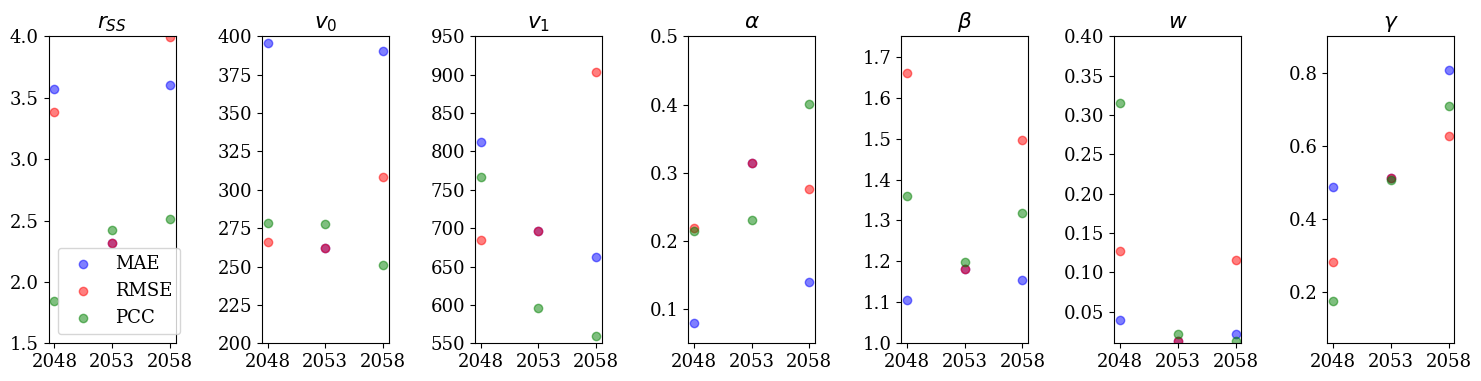

In [8]:
fig, ax = plt.subplots(ncols=7, figsize=(15, 4))

for ii in range(7):
    ax[ii].scatter(np.arange(3), initial_MAE[:, ii], c="blue", alpha=0.5, label="MAE")
    ax[ii].scatter(np.arange(3), initial_RMSE[:, ii], c="red", alpha=0.5, label="RMSE")
    ax[ii].scatter(np.arange(3), initial_PCC[:, ii], c="green", alpha=0.5, label="PCC")
    ax[ii].set_ylim(l_bounds[ii], u_bounds[ii])
    ax[ii].set_xticks([0, 1, 2])
    ax[ii].set_xticklabels(["2048", "2053", "2058"])
    ax[ii].set_title(labels_list[ii])
_ = ax[0].legend()
plt.tight_layout()

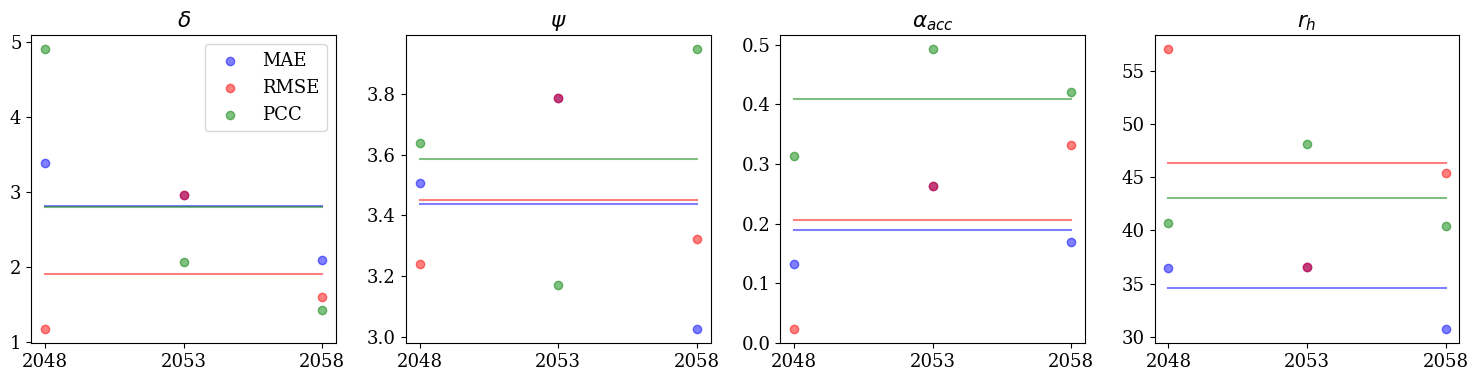

In [9]:
fig, ax = plt.subplots(ncols=4, figsize=(15, 4))

for ii in range(4):
    ax[ii].scatter(np.arange(3), deterministic_MAE[:, ii], c="blue", alpha=0.5, label="MAE")
    ax[ii].scatter(np.arange(3), deterministic_RMSE[:, ii], c="red", alpha=0.5, label="RMSE")
    ax[ii].scatter(np.arange(3), deterministic_PCC[:, ii], c="green", alpha=0.5, label="PCC")
    ax[ii].set_xticks([0, 1, 2])
    ax[ii].plot(np.arange(3), np.mean(deterministic_MAE[:, ii])*np.ones(3), c="blue", alpha=0.5)
    ax[ii].plot(np.arange(3), np.mean(deterministic_RMSE[:, ii])*np.ones(3), c="red", alpha=0.5)
    ax[ii].plot(np.arange(3), np.mean(deterministic_PCC[:, ii])*np.ones(3), c="green", alpha=0.5)
    ax[ii].set_xticklabels(["2048", "2053", "2058"])
    if ii ==0:
        ax[ii].set_title(r"$\delta$")
    elif ii ==1:
        ax[ii].set_title(r"$\psi$")
    elif ii ==2:
        ax[ii].set_title(r"$\alpha_{acc}$")
    elif ii ==3:
        ax[ii].set_title(r"$r_{h}$")
_ = ax[0].legend()
plt.tight_layout()



In [10]:
initial = np.mean(initial_MAE, axis=0)
initial

array([3.16435228e+00, 3.49519082e+02, 7.23709870e+02, 1.77866287e-01,
       1.14697740e+00, 2.46571473e-02, 6.01763647e-01])

In [11]:
log_posterior(initial)

-1324.3283400485147

### MCMC
MCMC is a procedure for generating a random walk in the parameter space that, over time, draws a representative set of samples from the distribution. Each point in a Markov chain $X(t_{i})$ depends only on the position of the previous step $X(t_{i−1})$. 

The MCMC Metropolis-Hastings method involves simultaneously evolving an ensemble of $K$ walkers $S = {X_{k}}$ where the proposal distribution for one walker $k$ is based on the current positions of the $K − 1$ walkers in the complementary ensemble $S_{[k]} = \{X_{j} , \forall j\neq k\}$.


Here, we use a Python implemtation of the affine-invariant ensemble sampler for Markov chain Monte Carlo (MCMC) proposed by Goodman & Weare (2010).

In [12]:
reader = emcee.backends.HDFBackend("MCMC_results/test.h5")

samples = reader.get_chain(flat=False)
samples_flatten  = reader.get_chain(flat=True)
log_prob_samples = reader.get_log_prob(flat=False)
log_prior_samples = reader.get_blobs(flat=False)
n_dim = 7

print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))

flat chain shape: (2, 15, 7)
flat log prob shape: (2, 15)


### A corner plot to show correlation (or lack thereof) of the seven model parameters.

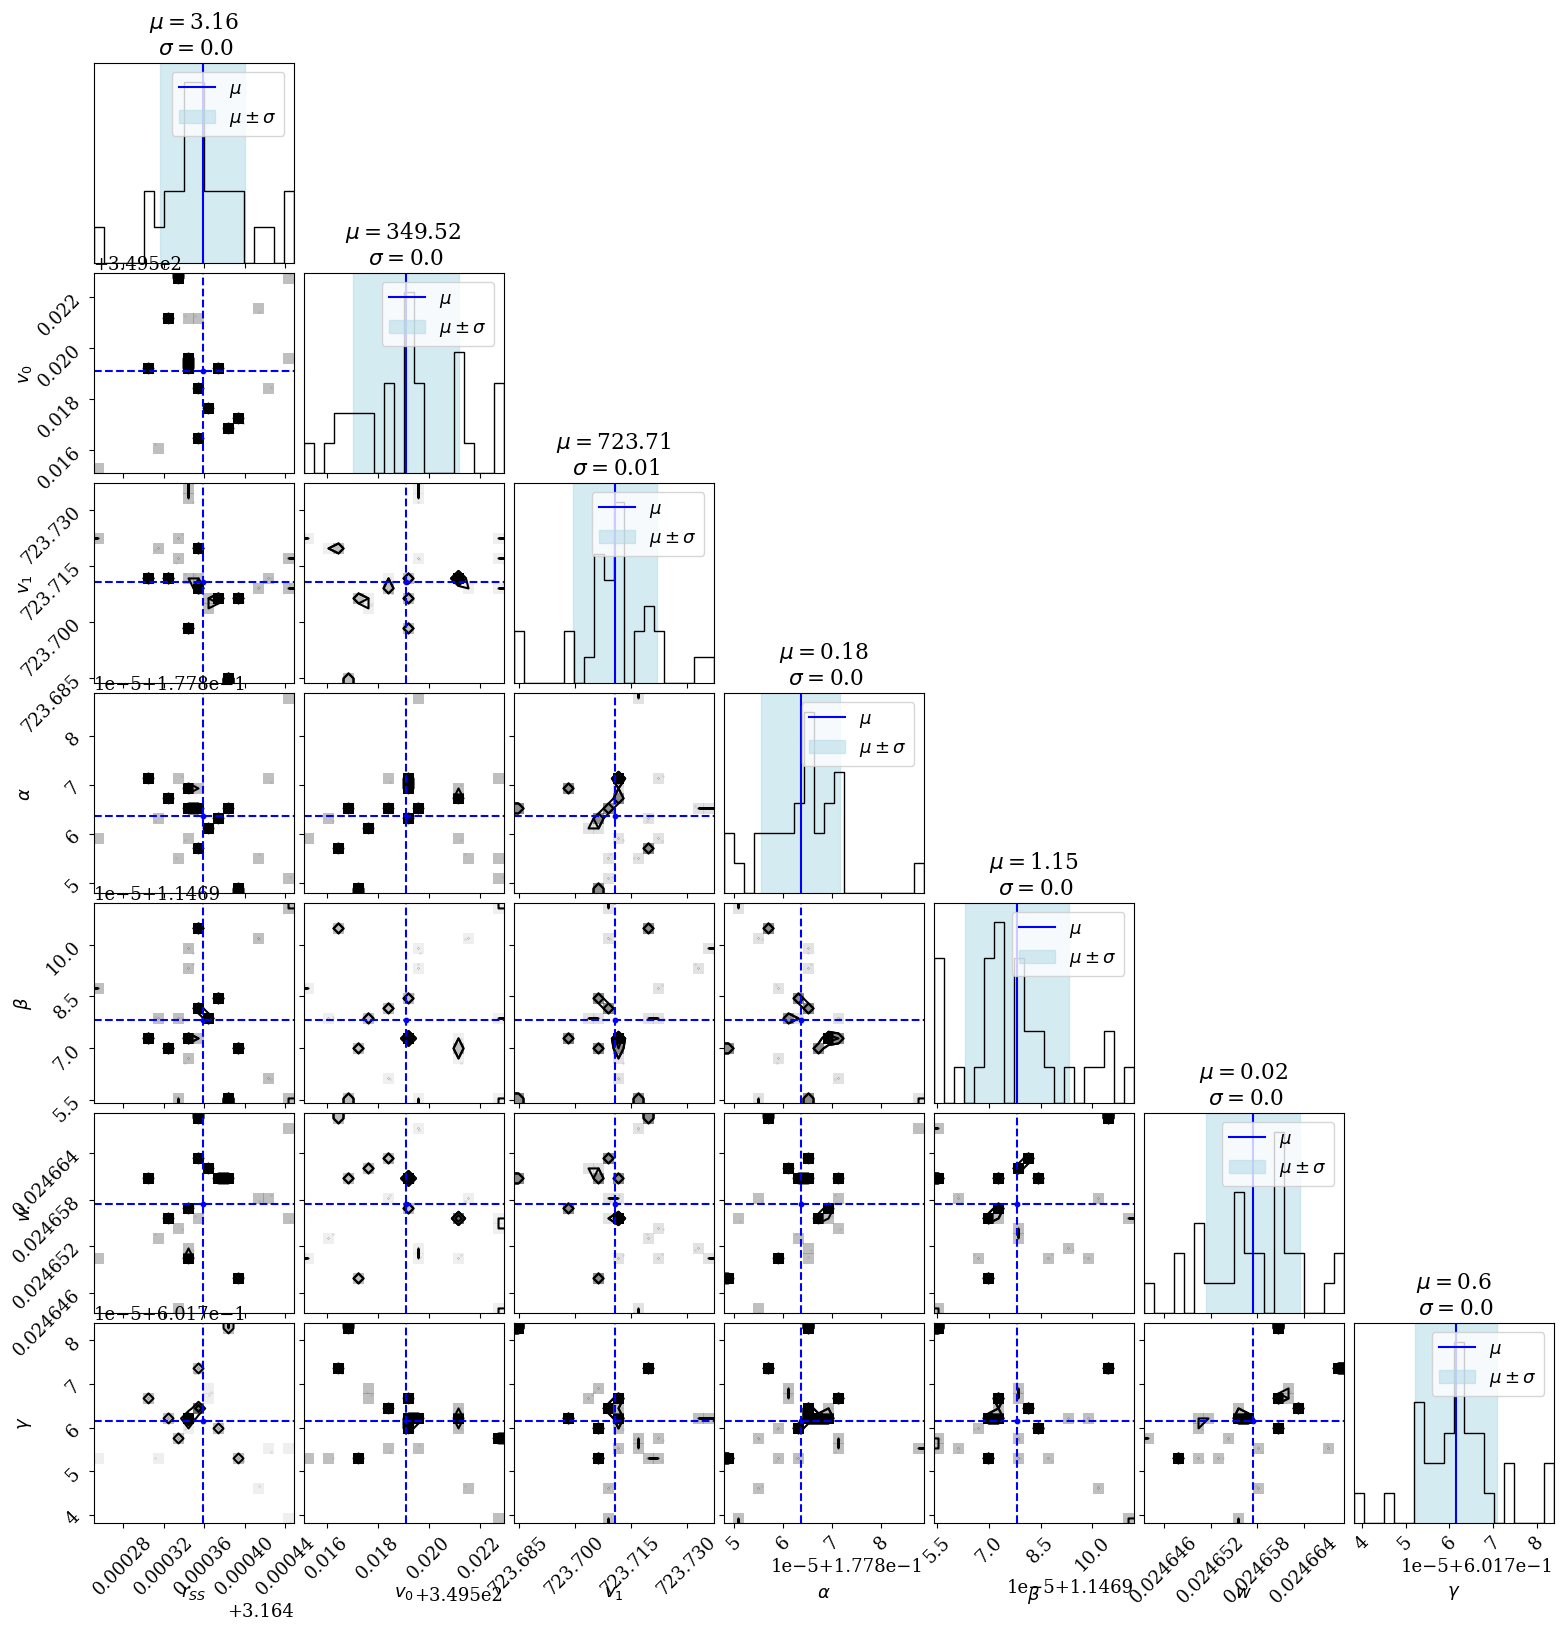

In [13]:
fig = corner.corner(samples_flatten, labels=[r"$r_{SS}$", r"$v_{0}$", r"$v_{1}$", r"$\alpha$", r"$\beta$", r"$w$", r"$\gamma$"])


# Extract the axes
axes = np.array(fig.axes).reshape((n_dim, n_dim))

for ii in range(n_dim):
    ax = axes[ii, ii]
    ax.axvline(np.mean(samples[:, :, ii]), label="$\mu$", color="blue")
    ax.axvspan(np.mean(samples[:, :, ii]) - np.std(samples[:, :, ii]), 
               np.mean(samples[:, :, ii])  + np.std(samples[:, :, ii]), 
               alpha=0.5,
               color="lightblue", 
               label="$\mu \pm \sigma$")
    ax.set_title("$\mu = $" + str(round(np.mean(samples[:, :, ii]), 2))
                 +"\n $\sigma = $" + str(round(np.std(samples[:,:, ii]), 2)))
    ax.legend()
    
# Loop over the histograms
for yi in range(n_dim):
    for xi in range(n_dim):
        if xi < yi:
            ax = axes[yi, xi]
            ax.axvline(np.mean(samples[:, :, xi]), color="blue", ls="--")
            ax.axhline(np.mean(samples[:, :, yi]), color="blue", ls="--")
            ax.scatter(np.mean(samples[:, :, xi]), np.mean(samples[:, :, yi]), color="blue", s=10)